# Chapter 4. Training Models

- In many situations, you need to understand the implementation of many algorithms.
- But understanding the underlying logic of machine learning algorithms will help you to:
    - Pick the right one for the task
    - Pick a good initial set of hyper-parameters
    - Pick a good training algorithm
    - ...
- lastly, most of the topics discussed in this chapter will be essential for understanding neural networks.
- In this chapter, we will start by lookin at linear regression training from two different angles:
    - Using a direct "closed-form" analytical method to get the optimal parameters for the linear model
    - Using an interative optimization method called gradient descent.
        - It gradually tweaks the model parameters until it converges to the same set of parameters found by method 1.
        - we will take a look at multiple types of gradient descent: stochastic GD, batch GD, Mini-batch GD.
- Next we will look at polynomial regression, or models that can fit non-linear datasets.
- Then we will look at several regularization techniques that will help up reduce the overfitting typically found in Polynomial models.
- Finally, we will look at two popular models used for classification tasks: Logistic regression & softmax regression.

## Linear Regression

- In chapter I, we looked at a simple model for *Life Satisfaction*:
$$life\_satisfaction = \theta_{0} + \theta_{1} \times GDP\_per\_capita$$
- This model is just a linear function of `GDP_per_Capita` with $\theta_{0}$ and $\theta_{1}$ as parameters.
- A linear model makes a prediction by simply computing the weighted sum of the input features + a constant called a bias term.
- More generally:
$$\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \dots + \theta_{n}x_{n}$$
- This can be written much more consicely using its vectorized form:
$$
\hat{y}=h_{\theta}(x)=\theta \cdot x \space | \space
\theta=\begin{bmatrix} \theta_{0}  \\ \theta_{1}  \\ \vdots  \\ \theta_{n} \end{bmatrix},
x=\begin{bmatrix} 1 \\ x_{1} \\ \vdots \\ x_{n} \end{bmatrix}
$$
- *Note:* $\cdot$ in $\theta \cdot x$ represent the dot product & not vector multiplication.
- $h_{\theta}(x)$ is the hypothesis function using parameters $\theta$.
- Note
    - In ML, vectors are often represented as column vectors.
    - Because $\theta$ and $x$ are both column vectors, we can write the prediction as follows:
$$\hat{y} = \theta^{T} x$$
        - Now, $\hat{y}$ is a single-cell matrix resulting from matrix multiplication.
    - In this book, we will use this notation to avoid switching between dot products and matrix multiplications.
- Training a model means adjusting its parameters so it best fits the data.
- For us to succeed, we first need to describe what do we mean by "best fitting the data". 
- We pick the mean sqaured error ($MSE$) as measure of the model performance:
$$MSE(X,h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T}x^{(i)} - y^{(i)})^2$$
- Where $X$ is the training data set represented as $X=\{(x_{1},y_{1}), (x_{2},y_{2}), \dots, (x_{m},y_{m})\}$

### The Normal Equation
- To find $\theta$ that minimizes the cost/loss function $MSE(\theta)$, there is a closed form solution.
- In other words, a mathematical equation that gives the result directly, and it's called the normal equation.
$$\hat{\theta}=(X^{T}X)^{-1}X^{T}y$$
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function $MSE(\theta)$.
- Let's generate some linear data to test this equation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

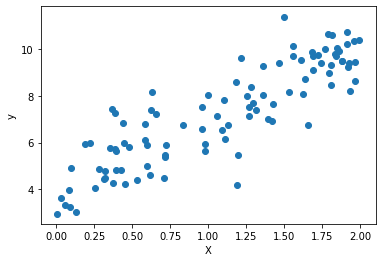

In [3]:
plt.scatter(x=X, y=y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

- Now let's compute $\hat{\theta}$ using the normal equation:

In [4]:
X_b = np.c_[np.ones_like(X), X]

In [5]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.97665388],
       [3.02159993]])

- The parameters that we used to generate the data (with some noise) are $\theta_{0}=4$ and $\theta_{1}=3$.
- The noise was responsible for not making it possible to recover the initial parameters $\theta_{0}$ & $\theta_{1}$.
- Now we can make predictions using our optimal parameters:

In [6]:
X_ = np.array([[0], [2]])
X_ = np.c_[np.ones_like(X_), X_].T
X_.shape

(2, 2)

In [7]:
y_hat = np.matmul(theta_best.T, X_)

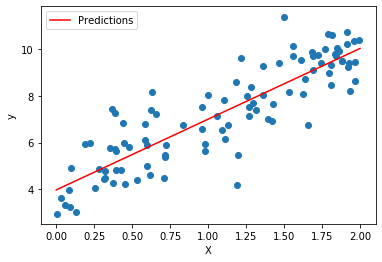

In [8]:
plt.scatter(x=X, y=y)
plt.plot([0,2], y_hat.flatten(), color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

- Performing Linear Regression using scikit-learn is also simple:

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lin_reg = LinearRegression(n_jobs=-1)

In [11]:
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [12]:
lin_reg.intercept_, lin_reg.coef_

(array([3.97665388]), array([[3.02159993]]))

In [13]:
lin_reg.predict(np.array([[0],[2]]))

array([[ 3.97665388],
       [10.01985374]])

- The `LinearRegression` class is based on `scipy.linalg.lstsq` function which you could call directly:

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [15]:
theta_best_svd

array([[3.97665388],
       [3.02159993]])

- The function computes $\hat{\theta}=X^{+}y$ where $X^{+}$ is the Moore-Penrose inverse, $X^{+}=(X^{T}X)^{-1}X^{T}$.
    - You can compute it directly:

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[3.97665388],
       [3.02159993]])

- The pseudoinverse itself is computed using a **standard matrix vectorization** technique called **Singular Value Decomposition** (SVD).
    - SVD can decompose the training set $X$ into the matrix multiplication of 3 matrices: $U \space \Sigma \space V^{T}$.
    - As a result, we have $X^{+}=V \Sigma^{+} U^{T}$
    - To compute the matrix $\Sigma^{+}$, the algorithm takes $\Sigma$ and:
        - Sets to zero all values smaller than an $\epsilon$
        - Replaces all the non-zero values with their inverse
        - Finally transposes the resulting matrix.
- This approach is more efficient than directly computing the normal equation
    - It handles edge cases nicely.
- The nomral equation may not work if $X^{T}X$ is not invertible but the pseudoinverse is always defined.

### Computational Complexity

- The normal equation computes the inverse of $X^{T}X$, which is an $(n+1) \times (n+1)$ matrix (where n is the number of features).
- The computation complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^{3})$, depending on the implementation.
- In other words, **if you double the number of features, you will increase the computation time by x5.3 to x8.**
- Notes
    - Both the normal equation & SVD approaches get very slow with a large number of features (100,000).
    - On a positive side, both are linear when it comes to the number of instances (or observations) you have in $X$.
- Once you trained your model using the Normal equation or SVD, predictions are exported really fast.
     - Linear complexity on both instances and features.
- Now we will look at a completely different way of finding the optimal parameters $\theta$
    - **It is suitable when you have too many features or instances you can't fit in memory**:

## Gradient Descent

- Gradient Descent is a generic optimization algorithm capable of finding solutions to a wide veriety of problems.
- The general idea of gradient descent is to tweak a model's parameters iteratively until we converge to an optimal set of parameters $\hat{\theta}$.
- Suppose you are lost in the mountain with dense fog, you can't see anything, you only can feel the ground below your feet. and you want to go home.
    - A good strategy is to move in the direction of the steepest slope.
    - This is exactly what gradient descent does.
- GD measures the local gradient of the error function with regards to the parameter function $\theta$ and goes in the direction of descending gradient.
- **Once the gradient is Zero, you have reached a minimum**.
- Practically, you start by initializing $\theta$ with random values (this is called **random initialization**).
- Then you improve it gradually, taking one baby step at a time.
    - Each step attempting to decrease the cost function, until you converge to a minimum:
    
<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/GD.png"></div>

- An important parameter in gradient descent is the size of the step, determined by the *learning rate* hyper-parameter.
    - If the learning rate is too small, the algorithm will take a long time to convert to a minimum.
    - If the learning rate is too big, the algorithm my jump infinately between intervals or even diverge.
- Finally, not all cost functions look like nice, regular bowls.
    - there may be holes/ridges/plateaus and all sorts of irregular terrains.
- The curvatures of most cost functions is challenging.
- As a result, the initialization of your parameters play an important role, depending on where did you start, you might end up in a place or another:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/Loss_curvature.png"></div>

- Fortunately, $MSE$ for Linear regression is a convex function, meaning, It's garanteed that the found minimum is th global minimum of the function.
    - No local minima, just one **global minimum**
- It's also a continuous function with a slope that never changes ubruptly (Lipschitz continuious).
- The Cost function has a shape of a bowl
    - But it can be an elongated bowl without feature scaling (because the dynamic range of each feature's parameter will be different):

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/scaling_effect.png"></div>

- By not doing feature scaling and by enforcing a constant learning rate for both feature parameters, the algorithm will take longer to reach the global minimum.
- Warning: When using gradient descent, make sure that all features are scaled.
- Briefly, when we are training the model, we are effectively **searching** for a parameter set that minimizes the cost function.
    - **It's a search in the model's parameter space**
        - The more parameters the model has, the more dimensions the space has, the harder for us to find the optimal set of parameters.

### Batch Gradient Descent

- To implement Gradient Descent, you need to compute the gradient of the cost function with regards to each model parameter $\theta_{j}$.
    - This is called a partial derivative.
- Let's compute the partial derivative of our previously defined cost function $MSE$:

$$\frac{\partial{J}}{\partial{\theta_{j}}}(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^{T}x^{(i)}-y^{(i)})x_{j}^{(i)}$$

- instead of computing the partial derivatives individually, we can give a general expression for batch mean squared error gradient:
- We have:
$$MSE(\theta)=\frac{1}{m}(X\theta - y)^2$$
- So:
$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X\cdot(X\theta-y)$$
- & because we prefer matrix multiplication over the dot product notation:
$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X^{T}(X\theta-y)$$
- Because, for two vectors $w$ and $x$:
$$w \cdot x = w^{T}x$$
- Notice that this formula involves calculating the gradient over the whole training set ($X$) for every learning step.
    - This is why this algorithm is called `Batch Gradient Descent`, the batch represending teh whole training set.
    - As a result, It's very slow on large training sets.
    - However, GD scales well with the number of features.
- Once you have the gradient vector, which points uphill, go in the opposite direction to go downhill.
- The gradient descent algorithm:
$$\theta^{\space(next \space step)} = \theta - \eta \nabla_{\theta}MSE(\theta)$$
- Let's look at a quick implementation of this algorithm:

- Data Preparation:

In [17]:
X = np.linspace(start=0, stop=1, num=100)
y = (0.5 * X) + 0.1 + 0.3 * np.random.rand(100)

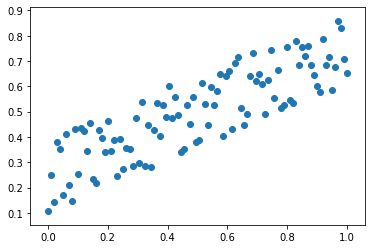

In [18]:
plt.scatter(x=X, y=y)
plt.show()

Next, we append `1`s to X:

In [19]:
X = np.c_[np.ones_like(X), X]

We then randomly initialize the parameters:

In [20]:
theta = np.random.rand(2)

In [21]:
def mse(X, y, theta):
    """Returns the Mean Squared Error.
    
    # Arguments:
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Returns
        MSE, float: Mean Squared Error between `X*theta` and `y`.
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 1./m * np.matmul((X_theta - y).T, (X_theta - y))

In [22]:
def grad_mse(X, y, theta):
    """Returns MSE's Gradient Vector.
    
    # Arguments
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Results
        grad_mse, np.ndarray: the gradient vector of the mean squared error function. 
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 2./m * np.matmul(X.T, X_theta - y)

Let's choose a learning rate:

In [23]:
lr = 0.01

Now let's optimize our model parameters, $\theta_{0}$ and $\theta_{1}$:

In [24]:
while mse(X, y, theta) > 0.01:
    theta = theta - lr * grad_mse(X, y, theta)

In [25]:
mse(X, y, theta)

0.009984604095016291

Let's check our parameters:

In [26]:
theta

array([0.27170469, 0.52543272])

Finally, let's check what our model learned:

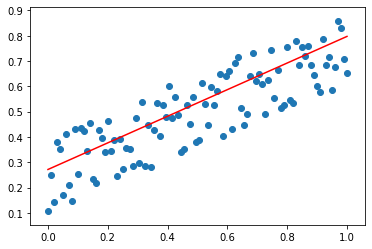

In [27]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0] + theta[1]*0, theta[0] + theta[1]*1], color='red')
plt.show()

- Batch Gradient Descent worked perfectly.
- What if you had used a different learning rate $\eta$?
- The following figure shows the first 10 steps of gradient descent using different learning rates (the dashed line represents the initial one):

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/different_lrs.png"></div>

- On the left the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time.
- In the middle, the learning rate looks pretty good: in just a few iterations, it had already converged to a solution.
- On the right, the learning rate is too high, the algorithm diverges, jumping all over the place and actually getting away from the solution.
- To find a good learning rate, you may want to try grid/random search
    - use just a few iterations to get an idea of a good learning rate without spending a lot of resources (compute or time)
- You may wonder how to find a good iterations number
    - If you set it low, you'll miss on a better trained model and consequently, better results.
    - If you set it high, you'll waste resources after your model has already converged.
    - A good simple strategy is to **Set a very large number of iterations then interrupt training when you start getting very small gradient values**
        - Meaning the parameters are (almost) not changing.
- When the cost function is convex and its slope doesn't change abruptly (as in the case of our MSE loss function) Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait for it to get there. 
    - It can take $O(\frac{1}{\epsilon})$ with $\epsilon=d(\hat{\theta}, \theta)$ depending on the shape of the cost function
    - If you devide the tolerance by 10 to have a more precise solution, then the algorithm may run for 10 times longer.

### Stochastic Gradient Descent

- The whole problem with batch gradient descent is that it uses the whole training set at each step to calculate the gradients & optimize the parameters.
    - Which **makes it very slow if the training set is large**.
- At the opposite extreme, **Stochastic Gradient Descent picks only 1 point and calculate the gradients and update the parameters based on it**.
- Working on 1 data point at a step makes the algorithm really fast.
- It also makes it possible to train on very large data sets since at each step only one data point is needed in memory.
- On the other hand, because it only relies on 1 data point at a time (picked randomly) the algorithm is not stable and the loss function doesn't decrease gradually, it decrease if we average multiple steps.
- Over time, SGD will get the parameters such as $J(\theta)$ is very close to 0 but it will continue to bounce up and down due to it picking 1 point at a time.

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/SGD_Loss.png"></div>

- When the loss curve is irregular, SGD might actually manage to jump out of a local minimum.
- So SGD has a better chance to find the global minimum than BSG has because SGD is not as stable in optimizing the parameters of the model.
- **Randomness is Good to Espace local minimas but bad because you will never settle on a minima**.
    - This can be addressed by **Gradually decreasing the learning rate as the algorithm trains**.
        - The steps starts out large which help the algorithm escape local minima.
        - Then get smaller & smaller, allowing the algorithm to settle on the global minima.
    - This proceess is akin to **simulated annealing**
- The function that determines the learning rate at each iteration is called the learning rate schedule.
- If the learning rate get reduced too quickly, you may get stuck at a local minimum, and if the learning rate get reduced very slowly it might not have any effect on stabalizing the algorithm over the global minimum and ie algorithm will continue to bounce back and fourth.
- Before diving into the implementation, let's present the formulation of the new loss function & its gradient for Stochastic Gradient Descent:
    - With SGD, we randomly select 1 point from $X$ at each step and feed it to the model, meaning:

$$J(\theta)=(x^{(i)}\theta - y^{(i)})^{2} \setminus x^{(i)} \in \Bbb{R}^{1 \times n}, \theta \in \Bbb{R}^{n \times 1}, y^{(i)} \in \Bbb{R}^{1 \times 1}$$
$$\nabla_{\theta}J(\theta)=2{x^{(i)}}^{T}(x^{(i)}\theta - y^{(i)})$$

- This code implements stochastic gradient descent using a simple learning schedule:

In [28]:
def sgd_loss(X_i, y_i, theta):
    """Returns the Mean Squared Error for Stochastic gradient descent.
    
    # Arguments:
        X_i, np.ndarray shape=(1,n): the intput training data row vector with `1` in the beginning.
        y, np.ndarray shape=(1,1): the target of the training row.
        theta, np.ndarray shape=(n,1): the parameters vector of the model.
    
    # Returns
        MSE, float: Mean Squared Error between `X*theta` and `y`.
    """
    X_theta = np.matmul(X_i, theta)
    return (X_theta - y_i)**2

In [29]:
def grad_sgd_loss(X_i, y_i, theta):
    """Returns Stochastic Gradient Descent's Mean Squared Error Gradient.
    
    # Arguments
        X_i, np.ndarray shape=(1,n): the intput training data row vector with `1` in the beginning.
        y, np.ndarray shape=(1,1): the target of the training row.
        theta, np.ndarray shape=(n,1): the parameters vector of the model.
    
    # Results
        grad_mse, np.ndarray: the gradient vector of the mean squared error function. 
    """
    X_theta = np.matmul(X_i, theta)
    return 2. * X_i.T * (X_theta - y_i)

In [30]:
def learning_rate_scheduler(lr, perc):
    """Returns annealed learning rate based on current one & reduction percentage
    
    # Arguments
        lr: float, initial learning rate
        perc: float \in [0,1]: annealing percentage
    
    # Returns
        next_lr: float, next learning rate to use
    """
    return perc * lr

In [31]:
theta = np.random.rand(2)

In [32]:
lr, steps = 0.1, 100000

for _ in range(steps):
    random_idx = np.random.randint(low=0, high=X.shape[0])
    lr = learning_rate_scheduler(lr, perc=0.99) 
    theta = theta - lr * grad_sgd_loss(X[random_idx], y[random_idx], theta)

In [33]:
sgd_loss(X[random_idx], y[random_idx], theta)

6.870176640292642e-05

Let's check our parameters:

In [34]:
theta

array([0.31028969, 0.39165335])

Finally, let's check what our model learned:

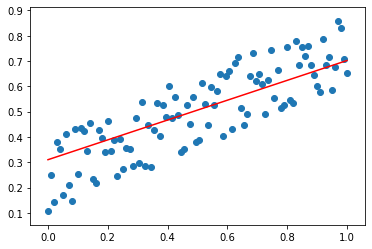

In [35]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0] + theta[1]*0, theta[0] + theta[1]*1], color='red')
plt.show()

- We can see that breaking training based on local loss (between the current random point & its target) is not good
    - Because we might have a very good local loss but the global loss is still far from minimized
- We didn't support epochs & we're not guaranteeing looping over all training points.
- Our learning rate decreaser is primitive.
- We're not preserving dimensions as we consider $1 \times 1$ as a $cte \in R$. 
- Let's go over the book's solution:

In [36]:
n_epochs = 50
t0, t1 = 5, 50
m = X.shape[0]

In [37]:
def learning_schedule(t):
    return t0 / (t + t1)

In [38]:
theta = np.random.randn(2, 1)

In [39]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1] 
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) 
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [40]:
theta

array([[0.27367049],
       [0.45948649]])

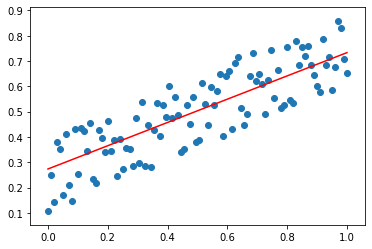

In [41]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0][0] + theta[1][0]*0, theta[0][0] + theta[1][0]*1], color='red')
plt.show()

- By convention we iterate by rounds of $m$ iterations, each round is called an **epoch**.
- While the Batch Gradient Descent algorithm iterate for 1,000 times to converge, we only iterated for 50 times.
- Notice that some rows may be picked several times, and others may not be picked at all.
    - If you want to make sure you feed all instances per epoch, in the beginning of each epoch:
        - Shuffle (X, y) jointly by index
        - Loop over their rows row by row
    - However, this method is known to **converge more slowly**
- When using SGD, the rows must be independent and identically distributed
    - Make sure you randomly shuffle the rows or pick each one at random
    - If you don't do this, the algorithm might lean towards trends in the last couple of rows you fed it
        - For example, if you sort by label value then feed.
    - Stochastic sampling insures convergance towards the global minimum.
- We can also do it the scikit-learn way:

In [42]:
from sklearn.linear_model import SGDRegressor

In [43]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)

In [44]:
sgd_reg.fit(X=X, y=y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [45]:
sgd_reg.coef_

array([0.14965197, 0.38712296])

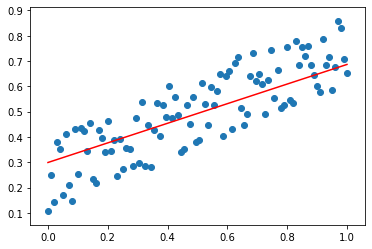

In [46]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [sgd_reg.predict(X=[[1, 0]]), sgd_reg.predict(X=[[1, 1]])], color='red')
plt.show()

### Mini-Batch Gradient Descent

- At each step, instead of computing the gradients on a single randomly picked instance (SGD) or the full training set (BGD), Mini-Batch gradient descent computes its gradients on randomly selected set of instances.
    - the samples are called **Mini-Batches**
- The main advantage of MBGD over SGD is the performance boost in matrix operations that you get especially from GPUs.
- Intuitively, MBGD's parameter optimization process is less erratic than SGD because the fed sample is more representative than one randomly selected point.
    - Especially for fairly big mini-batch sizes.

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/algos_comparison.png"></div>

- The previous figure shows the path taken by BGD, SGD, MBGD.
    - They all endup near the minimum
    - Batch Gradient Descent actually stops at the minimum
    - While both SGD & MBGD continue to walk around
- Don't forget that batch gradient descent takes a long time to converge because we're computing the gradients over the whole training set at each step.
- **SGD & MBGD will also converge to the minimum if you use a good learning rate schedule**

## Polynomial Regression

- What if your data is more complex than a straight line?
- You can you a linear model to fit non-linear data.
- A simple way to do this is to **add powers of each feature as new features then train a linear model on this set of features**.
    - This technique is called polynomial regression
- Let's look at an example, let's generate some nonlinear data, based on a simple quadratic equation + some noise:

In [47]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

- Basically:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

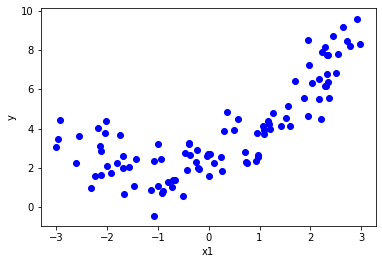

In [48]:
plt.scatter(X, y, color='blue')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

- Clearly a straight line will never fit this data properly.
- As a solution, let's add $x^{2}$ as a new feature to $X$, then train a simple linear model:

In [49]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [51]:
X_poly = poly_features.fit_transform(X)

In [52]:
X_poly[:3]

array([[-2.12842571,  4.530196  ],
       [ 1.27442241,  1.62415249],
       [ 1.95234246,  3.81164107]])

In [53]:
lin_reg = LinearRegression()

In [54]:
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
lin_reg.intercept_, lin_reg.coef_

(array([2.31113668]), array([[0.93440288, 0.46813083]]))

- Let's plot it:

In [56]:
X_p = np.linspace(start=-3, stop=3, num=100).reshape(-1, 1)
X__p = poly_features.transform(X_p)
y_p = lin_reg.predict(X=X__p)

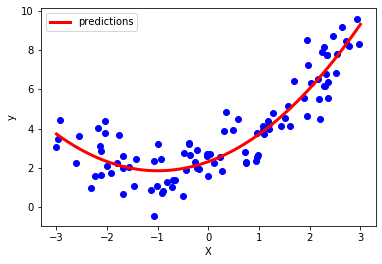

In [57]:
plt.scatter(X, y, color='blue')
plt.plot(X_p, y_p, color='red', label='predictions', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

- Not bad, training results in the following hypothesis:

$$y= (0.50463537) * x^{2} + (1.07951347) * x + 2 + 0.03834072$$

- Which is very close to:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

- When we have multiple features, polynomial linear regression is capable of finding relationships between features.
    - Which is something a plain linear regression model cannot do.
    - This is made possible by the fact that `PolynomialFeatures` adds all possible combinations of features up to a certain degree.

## Learning Curve

- If you fit your training data with polynomial regression, you will likely fit it much better than with just `LinearRegression`
- But beware that as you augment the degree of your polynomial regression hypothesis, you're giving it more predictive power:

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/Power_degrees.png"></div>

- Notice how the 300degree polynomial model wiggles around to get as close as possible to all of the training data points.
- Degree 1 — **Underfitting**
- Degree 2 — **Fitting**
- Degree 300 — **Overfitting**
- Because we generated synthetic data using a qudratic function, we know that degree 2 is good.
    - But in most cases, we won't know the function that generated the data!
- The next logical questions is: "How to know if our model is overfitting or underfitting?"
- The validation dataset is to the rescue:
    - If our model performs good on the training data but badly on the validation data — **Overfitting**
    - If our model performs badly on the training data & badly on the validation data — **Underfitting**
    - If our model performs good on the training data & good on the validation data — **Fitting**
- Another way to tell if you're overfitting/underfitting is to look at the learning curves.
    - Curves that showcase performance over the training set versus validation set with varying training set sizes.
    - To generate the plot, train the same model on different training set sizes:

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [99]:
def plot_learning_curve(model, X, y):
    """Plots model training/validation's MSE over different sizes of training sets.
    
    # Arguments
        model: sklearn.*, a scikit-learn model to be trained/tested.
        X: np.ndarray, the input dataset.
        y: np.ndarray, the output dataset.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    train_errors, val_errors = list(), list()
    for m in range(1, X_train.shape[0]):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Loss')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='Validation Loss')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.show()

- Let's look at the learning curves of a plain linear regression model:

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
lin_reg = LinearRegression()

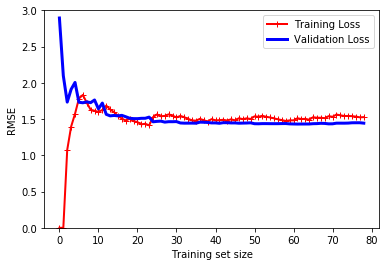

In [107]:
plot_learning_curve(lin_reg, X, y)

- When there are 1 or 2 instances in the training set, the model can fit them perfectly.
- But when we add more training data, it becomes impossible for the model to fit all of them perfectly.
    - Both because the data is noisy and because the data isn't linear at all.
- the training RMSE converges to a plateau and if we add more data, RMSE doesn't get effected as much.
- On the other hand, when the model is trained on a few instances, it's not able to generalize well hence the bad losses for val.
- Then as the model is shown more examples, it learns general patterns and the val error converges to the training error.
- **These curves are typical for a model that is underfitting**
    - Both curves have reached a plateau, they are close and very high.
- If your model is underfitting the data, **adding more data points will not help**, you need to **add more features or use a more complex model**.
- Let's fit and visualize the curves of a 10-degree polynomial model:

In [108]:
from sklearn.pipeline import Pipeline

In [109]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

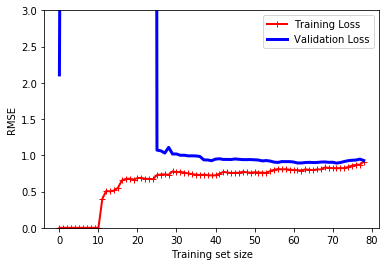

In [111]:
plot_learning_curve(polynomial_regression, X, y)

- These learning curves look very similar to the previous ones, but there are some key differences:
    - The error on the training data is much lower than in the previous example.
    - there is a **gap** between the curves, meaning the model performs much better on the training set than on the validation set.
        - Which is the hallmark of an overfitting model.
- One solution to overfitting **is to have more training data until the validation loss reaches the training loss**.
- The Bias-Variance Tradeoff
    - An important theoretical result of statistics and ML is that the generalizability error can be expressed as the sum of three very different erros:
        - **Bias** — Has to do with wrong assumptions, like assuming the data is linear when It's actually quadratic.
            - A high bias model is most likely to underfit the training data.
        - **Variance** — Has to do with a model's excessive sensitivity to the training data
            - A high variance model tends to overfit the training data.
        - **Irreducible Error** — Due to the noisiness of the data itself.
            - The only way to reduce this error is to fix the data.
    - Increasing a model's complexity will typically increase its variance and decrease bias (with a less restricted model).
    - & Reducing the model's complexity will increase bias and decrease variance.
    - This is why It's called a trade-off.

## Regularized Linear Models

- A good way to reduce overfitting is to regularize the model (contrain it)
- A simple way to regularize a polynomial model is to reduce the number of degrees it has.
- For a linear model, regularization is typically achieved by constraining the model's weights range.
- Let's look at 3 methods to contraint the weights of a linear model: 

### Ridge Regression

- It's a regularized version of linear regression: a regularized term $\alpha \sum_{i=0}^{n}\theta_{i}^{2}$ is added to the cost function, meaning:

$$J(\theta)=\frac{1}{m}(X\theta-y)^{T}(X\theta-y) + \alpha \frac{1}{2} \theta_{\neq 0}^{T} \theta_{\neq 0}$$
$$\nabla_{\theta} J(\theta)=\frac{2}{m}X^{T}(X\theta-y) + \alpha \begin{bmatrix}\theta_{\neq 0} \\ 0\end{bmatrix}$$

- This forced the model not only to fit the data but to try to keep the weights as small as possible.
- The regularization term should only be used during training, once the model is trained, you'll want to use the unregularized loss for performance evaluation.
- It's quite common for the loss function used during training not to be used during testing/evaluation.
    - Good training cost function should have optimization-friendly derivatives
    - While the performance measure used in testing should be as close as possible to the objective.
        - Many of evaluators aren't differientiable.
        - Ex. In classification we train using Log-Loss but we evaluate with Accuracy/Precision/Recall
- The hyper-parameter $\alpha$ is used to control how much you want to regularize the model
- Note that the bias term is not regularized, because $\theta_{0}$ doesn't contribute to the curvature of the model (It contributes to its *shift*).
- Feature scaling is very important before performing Ridge Regression since it's sensitive to the values of each weight.
- .. 